# Quantifying the Ade2 locus editing efficiency of the Eco1RT - Cas9 system

### Import packages

In [1]:
import sys,os, glob
import shutil

import matplotlib as plt
plt.rcParams['pdf.fonttype'] = 42

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns

from Bio import SeqIO
import fuzzysearch
import re
from collections import Counter, OrderedDict
from Bio.Seq import Seq

In [2]:
run = "./miseq/msSBK_20-289937656/FASTQ_Generation_2021-08-10_17_10_50Z-447830383"
os.chdir(run)

### load dataframe of sample ID and conditions 

In [3]:
samples = pd.read_excel("samples.xlsx")[["sample_name", "description", "Sub-Library Owner"]]
samples

,sample_name,description,Sub-Library Owner
0,msSBK_20_01,oligo_set_2-A_Co,CF
1,msSBK_20_02,oligo_set_2-A,CF
2,msSBK_20_03,oligo_set_2-C_Co,CF
3,msSBK_20_04,oligo_set_2-C,CF
4,msSBK_20_05,Eco1 110,CP
...,...,...,...
188,msSBK_20_188,NaN,NaN
189,msSBK_20_189,NaN,NaN
190,msSBK_20_190,NaN,NaN
191,msSBK_20_191,NaN,NaN


### define env

In [16]:
print ("="*60)
for file in glob.glob("msSBK_*_*"):
    fn = file.split("_L001")[0]
    condition = samples["description"][samples["sample_name"]==fn].to_string(index=False)
    owner = samples["Sub-Library Owner"][samples["sample_name"]==fn].to_string(index=False)
    
    if "SCL" in owner:
       
        print (fn + " -- " + condition)
        os.chdir(file)
        r1 = glob.glob("*R1_001*")[0]
        print (r1)
        
        print ("\ntrimming files\n")
        cmd = "sickle se -f {0} -t sanger \
                -o trimmed_R1.fastq".format(r1)
        os.system(cmd)    
        print ("="*60)

        os.chdir(run)
        
    else:
        #pass
        shutil.rmtree(file, ignore_errors=True)
os.chdir(run)

 SCL/SKL
msSBK_20_115 --  HEK293T +139 +141 +dox day3 R2
msSBK-20-115_S115_L001_R1_001.fastq.gz

trimming files

 SCL
msSBK_20_170 --  ySCL55 24h R2
msSBK-20-170_S170_L001_R1_001.fastq.gz

trimming files

 SCL/SKL
msSBK_20_161 --  HEK293T +140 +eletroporation4.5ug -dox day1 R2
msSBK-20-161_S161_L001_R1_001.fastq.gz

trimming files

 SCL/SKL
msSBK_20_105 --  HEK293T +140 +141 +dox day3 R1
msSBK-20-105_S105_L001_R1_001.fastq.gz

trimming files

 SCL/SKL
msSBK_20_150 --  HEK293T +140 +lipoRNA1000 -dox day1 R3
msSBK-20-150_S150_L001_R1_001.fastq.gz

trimming files

 SCL
msSBK_21_22 --  ySCL55 48h R1
msSBK-21-22_S22_L001_R1_001.fastq.gz

trimming files

 SCL/SKL
msSBK_20_127 --  HEK293T +139 +141 +dox day3 R3
msSBK-20-127_S127_L001_R1_001.fastq.gz

trimming files

 SCL
msSBK_21_39 --  ySCL86 48h R3
msSBK-21-39_S39_L001_R1_001.fastq.gz

trimming files

 SCL
msSBK_21_24 --  ySCL55 48h R3
msSBK-21-24_S24_L001_R1_001.fastq.gz

trimming files

 SCL
msSBK_20_181 --  ySCL92 24h R1
msSBK-20-181_S18

### parse files and pull indel profile

In [17]:
# define genomic region of interest
Region_dict = {'ADE2': {'flanking': ['GGGAATTGCTTATTAACGAA','CACAACTCTGGACATTATAC'], 'wt_or_edited': ['ATTGCCCCAAGGCCT','ATTGCCTGAAGGCCT']}}

def extract_and_exact_match(sequence):
	left_flank = fuzzysearch.find_near_matches(Region_dict[edit_site]['flanking'][0],sequence,max_l_dist=0)
	right_flank = fuzzysearch.find_near_matches(Region_dict[edit_site]['flanking'][1],sequence,max_l_dist=0)
	if len(left_flank) == 1 and len(right_flank) == 1:
		region = sequence[left_flank[0].end:right_flank[0].start]
		if region == Region_dict[edit_site]['wt_or_edited'][0]:
			return ('wt', region)
		elif region == Region_dict[edit_site]['wt_or_edited'][1]:
			return ('edited', region)
		else: return ('undetermined_no_site_match', region)
	else: return ('undetermined_no_flanking_match', None)

In [18]:
os.chdir(run)

df_exact_files = pd.DataFrame(columns=["sample_name", "condition", "wt", "edited",
                                 "undetermined_no_flanking_match", 'undetermined_no_site_match',
                                 "total reads", "edited_percent"])
fastq_reads = "trimmed_R1.fastq"
edit_site = "ADE2"
print ("="*60)

non_precise_exact = {}
for file in glob.glob("msSBK_*_*"):
    fn = file.split("_L001")[0]
    condition = samples["description"][samples["sample_name"]==fn].to_string(index=False)
    if "ySCL" in condition:
        non_precise_exact[condition] = []
print (non_precise_exact)

for file in glob.glob("msSBK_*_*"):
    fn = file.split("_L001")[0]
    condition = samples["description"][samples["sample_name"]==fn].to_string(index=False)
    if "ySCL" in condition:
        npe = []
        all_reads_str = []
        outcomes_dict = {'wt':0,
                     'edited':0,
                     'undetermined_no_flanking_match':0,
                     'undetermined_no_site_match':0}

        print (fn + " -- " + condition)
        os.chdir(file)

        filename = glob.glob("*.fastq.gz")

        for seq_record in SeqIO.parse(fastq_reads, "fastq"):
            all_reads_str.append(str(seq_record.seq))
        read_counter = Counter(all_reads_str)
        for read in read_counter:
            if extract_and_exact_match(read)[0]=='undetermined_no_site_match':
                #print (extract_and_exact_match(read)[1])
                npe.extend([extract_and_exact_match(read)[1]]*read_counter[read])
                #print (npe)
                
            outcomes_dict[extract_and_exact_match(read)[0]] += read_counter[read] 
        try:
            #edited_percent = (float(outcomes_dict['edited'])/float(outcomes_dict['edited']+outcomes_dict['wt']))*100
            edited_percent = (float(outcomes_dict['edited'])/float(outcomes_dict['edited']+
                                                                   outcomes_dict['wt']+
                                                                   outcomes_dict["undetermined_no_site_match"]
                                                                   #outcomes_dict["undetermined_no_flanking_match"]
                                                                ))*100
        except:
            print (float(outcomes_dict['edited']), float(outcomes_dict['edited']), outcomes_dict['wt'])
            edited_percent = 0
        
        print ('{0} percent edited ({1} edited/ {2} wt)'.format(edited_percent,outcomes_dict['edited'],outcomes_dict['wt']))
        print ('{0} do not contain clean flanking regions'.format(outcomes_dict['undetermined_no_flanking_match']))
        print ('{0} contain flanking regions, but not a clean target site match to edited or wt'.format(outcomes_dict['undetermined_no_site_match']))
        print ("parsing done.\n"+ "="*60 + "\n")

        df_exact_files = df_exact_files.append({"sample_name": fn, "condition": condition, 
                                     "wt": outcomes_dict['wt'], "edited": outcomes_dict['edited'],
                                     "undetermined_no_flanking_match": outcomes_dict['undetermined_no_flanking_match'],
                                     'undetermined_no_site_match': outcomes_dict['undetermined_no_site_match'],
                                     "total reads": outcomes_dict['wt'] + outcomes_dict["edited"] + outcomes_dict['undetermined_no_flanking_match'] + outcomes_dict['undetermined_no_site_match'],
                                     "edited_percent": edited_percent, 
                                     "non_precise_edits_percent": outcomes_dict['undetermined_no_site_match']/(outcomes_dict['wt'] + 
                                                                                                               outcomes_dict["edited"] + 
                                                                                                               #outcomes_dict['undetermined_no_flanking_match'] + 
                                                                                                               outcomes_dict['undetermined_no_site_match'])*100},
                                    ignore_index=True,)
        #print (npe)
        non_precise_exact[condition]+=npe
    os.chdir(run)

{' ySCL55 24h R2': [], ' ySCL55 48h R1': [], ' ySCL86 48h R3': [], ' ySCL55 48h R3': [], ' ySCL92 24h R1': [], ' ySCL77 48h R1': [], ' ySCL77 24h R1': [], ' ySCL76 48h R3': [], ' ySCL77 24h R2': [], ' ySCL56 48h R2': [], ' ySCL92 24h R2': [], ' ySCL92 24h R3': [], ' ySCL86 24h R3': [], ' ySCL77 48h R3': [], ' ySCL77 48h R2': [], ' ySCL76 48h R1': [], ' ySCL77 24h R3': [], ' ySCL92 48h R2': [], ' ySCL76 24h R3': [], ' ySCL56 24h R2': [], ' ySCL55 48h R2': [], ' ySCL92 48h R3': [], ' ySCL86 24h R1': [], ' ySCL76 24h R2': [], ' ySCL55 24h R3': [], ' ySCL92 48h R1': [], ' ySCL56 48h R3': [], ' ySCL86 48h R2': [], ' ySCL86 24h R2': [], ' ySCL56 24h R1': [], ' ySCL55 24h R1': [], ' ySCL56 24h R3': [], ' ySCL56 48h R1': [], ' ySCL86 48h R1': [], ' ySCL76 24h R1': [], ' ySCL76 48h R2': []}
msSBK_20_170 --  ySCL55 24h R2
2.749717227660985 percent edited (1410 edited/ 48561 wt)
6990 do not contain clean flanking regions
1307 contain flanking regions, but not a clean target site match to edited o

## Create a dataframe to store data for plotting

In [19]:
# allowing no mismatches in flanking region
df_exact_files[["placehold", "strain", "time", "comp"]] = df_exact_files["condition"].str.split(" ", n=4, expand = True)
df_exact_plot = df_exact_files.drop("placehold", axis=1)
df_exact_plot = df_exact_plot.sort_values("edited_percent")

# add genotype information about strains
d = {"ySCL39": "Eco1RT + Cas9 (long primer Eco1 ncRNA)",
    "ySCL55": "Eco1RT-Cas9 fusion (Cas2-1 linker) + long primer editing retron",
    "ySCL56": "Cas9-Eco1RT fusion (Cas2-1 linker) + long primer editing retron",
    "ySCL58": "Eco1RT + Cas9 + long primer editing retron, inverted msr - msd, internal sgRNA",
    "ySCL58": "Eco1RT + Cas9 + long primer editing retron, inverted msr - msd, internal sgRNA",
    "ySCL66": "mam-opt Sen2RT + Cas9 + Sen2 editing retron",
    "ySCL67": "mam-opt Eco4RT + Cas9 + Eco4 editing retron",
    "ySCL68": "Cas9 + Eco1RT {minimal actin intron: ncRNA editing retron}",
    "ySCL69": "Eco1RT-Cas9 fusion (Cas2-1 linker) + long primer editing retron, inverted msr - msd, internal sgRNA}",
    "ySCL70": "Cas9-Eco1RT fusion (Cas2-1 linker) + long primer editing retron, inverted msr - msd, internal sgRNA",
    "ySCL71": "Cas9 + Eco1RT, asymmetric donor on long primer editing retron",
    "ySCL76": "Eco1RT P2A Cas9 (long primer Eco1 ncRNA)",
    "ySCL77": "Cas9 P2A Eco1RT (long primer Eco1 ncRNA)",
    "ySCL92": "Eco1RT liu_linker Cas9 (long primer Eco1 ncRNA)",
    "ySCL86": "Cas9 liu_linker Eco1RT (long primer Eco1 ncRNA)"
     
    }
df_exact_plot["genotype"] = df_exact_plot["strain"].map(d)

display(df_exact_plot)

,sample_name,condition,wt,edited,undetermined_no_flanking_match,undetermined_no_site_match,total reads,edited_percent,non_precise_edits_percent,strain,time,comp,genotype
31,msSBK_20_174,ySCL56 24h R3,33184,1,3712,851,37748,0.002938,2.500294,ySCL56,24h,R3,Cas9-Eco1RT fusion (Cas2-1 linker) + long prim...
19,msSBK_20_173,ySCL56 24h R2,28094,4,3584,816,32498,0.013834,2.822162,ySCL56,24h,R2,Cas9-Eco1RT fusion (Cas2-1 linker) + long prim...
29,msSBK_20_172,ySCL56 24h R1,24147,4,5290,502,29943,0.016225,2.036263,ySCL56,24h,R1,Cas9-Eco1RT fusion (Cas2-1 linker) + long prim...
26,msSBK_21_27,ySCL56 48h R3,42905,16,892,346,44159,0.036980,0.799686,ySCL56,48h,R3,Cas9-Eco1RT fusion (Cas2-1 linker) + long prim...
32,msSBK_21_25,ySCL56 48h R1,29616,17,890,194,30717,0.056995,0.650417,ySCL56,48h,R1,Cas9-Eco1RT fusion (Cas2-1 linker) + long prim...
9,msSBK_21_26,ySCL56 48h R2,46507,141,1272,363,48283,0.299930,0.772160,ySCL56,48h,R2,Cas9-Eco1RT fusion (Cas2-1 linker) + long prim...
0,msSBK_20_170,ySCL55 24h R2,48561,1410,6990,1307,58268,2.749717,2.548851,ySCL55,24h,R2,Eco1RT-Cas9 fusion (Cas2-1 linker) + long prim...
20,msSBK_21_23,ySCL55 48h R2,35723,3075,1133,312,40243,7.862439,0.797750,ySCL55,48h,R2,Eco1RT-Cas9 fusion (Cas2-1 linker) + long prim...
24,msSBK_20_171,ySCL55 24h R3,32814,3245,5575,1087,42721,8.735799,2.926291,ySCL55,24h,R3,Eco1RT-Cas9 fusion (Cas2-1 linker) + long prim...
30,msSBK_20_169,ySCL55 24h R1,32485,3614,4868,994,41961,9.743078,2.679751,ySCL55,24h,R1,Eco1RT-Cas9 fusion (Cas2-1 linker) + long prim...


## Plot editing efficiency per strain and retron variant

<Figure size 432x288 with 0 Axes>

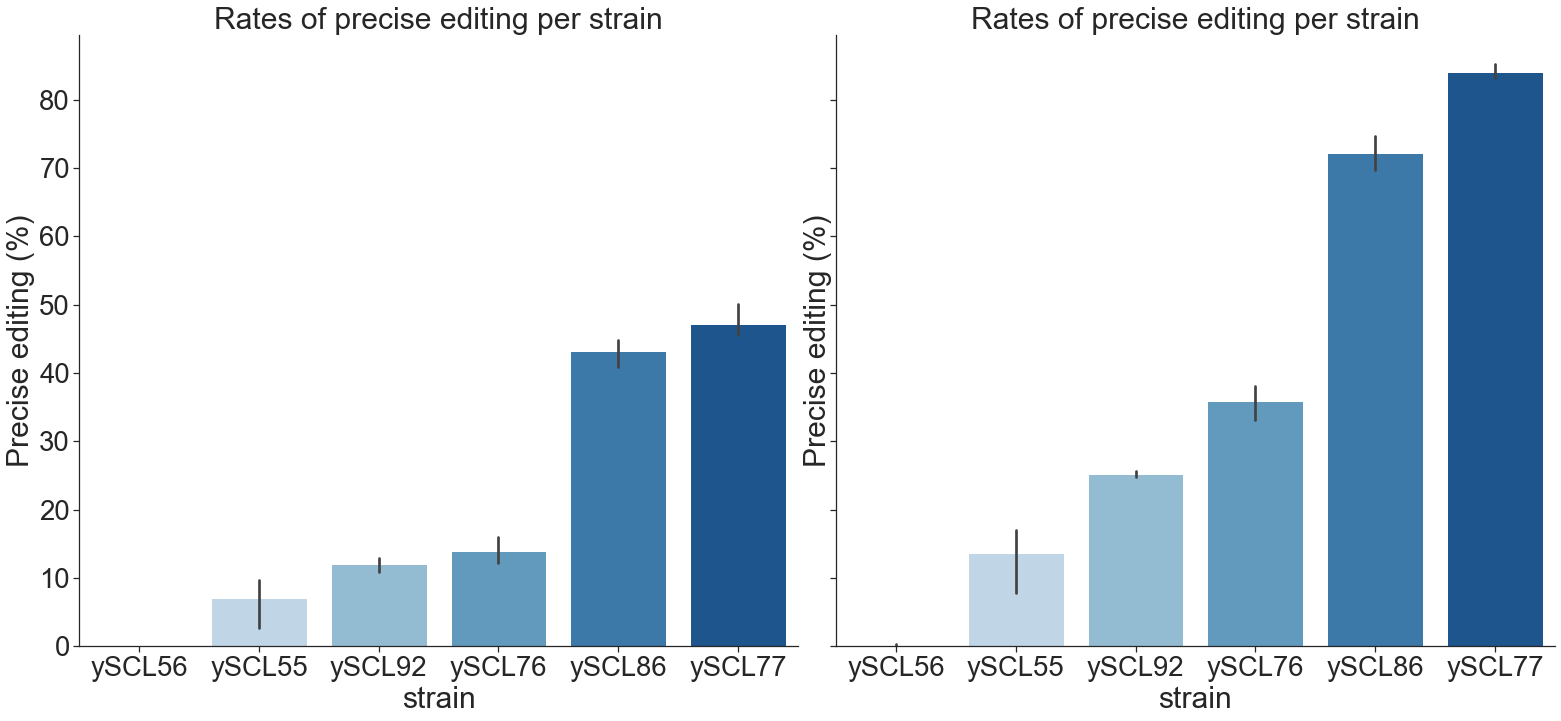

In [20]:
df_exact_plot = df_exact_plot.sort_values("edited_percent")

sns.set(font_scale = 2.5)

sns.set_style("ticks")
sns.despine()

g = sns.catplot(x="strain", y="edited_percent", hue = "genotype", palette="Blues",  col="time", col_order=["24h", "48h"],
                data=df_exact_plot, kind="bar", height=10.27, aspect=6.7/6.27,
               dodge=False, sharey=True, legend=False)#, label="small")


g.set(xlabel='strain', ylabel='Precise editing (%)', title="Rates of precise editing per strain")

g.set_xticklabels(rotation=0)#, fontsize=20)

g.savefig("all_new_strains_editing_percent_precise.pdf")
df_exact_plot.to_csv("yeast Cas9 - RT configs.csv", sep = "\t")
